In [4]:
import os
import sys
from starter import Starter


starter = Starter()
starter.start(lambda: os.chdir(os.path.dirname(os.getcwd())))


Starter has already been initialized.


In [10]:

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any
import time
import json
import os
from utils.metrics_calculator import MetricsCalculator
from utils.data_loader import DataLoader
from models.rnn import RNNModelBuilder
from layers.embedding  import EmbeddingLayer
from layers.bidirectional import BidirectionalLayer
from layers.simple_rnn import SimpleRNNCell, SimpleRNNLayer


class ExperimentRunner:
    """Run experiments for RNN hyperparameter analysis"""
    
    def __init__(self, data_dir: str, results_dir: str = "results"):
        self.data_dir = data_dir
        self.results_dir = results_dir
        self.data_loader = DataLoader(data_dir)
        
        # Create results directory
        os.makedirs(results_dir, exist_ok=True)
        
        # Store data
        self.X_train = None
        self.y_train = None
        self.X_valid = None
        self.y_valid = None
        self.X_test = None
        self.y_test = None
        
        # Experiment results
        self.experiment_results = {}
    
    def prepare_data(self, max_vocab_size: int = 10000, max_length: int = 100):
        """Prepare data for experiments"""
        print("Preparing data...")
        self.X_train, self.y_train, self.X_valid, self.y_valid, self.X_test, self.y_test = \
            self.data_loader.prepare_data(max_vocab_size, max_length)
        
        # Save preprocessor
        preprocessor_path = os.path.join(self.results_dir, "preprocessor.npy")
        self.data_loader.save_preprocessor(preprocessor_path)
        print(f"Preprocessor saved to {preprocessor_path}")
    
    def run_single_experiment(self, config: Dict[str, Any], experiment_name: str) -> Dict[str, Any]:
        """
        Run a single experiment with given configuration
        
        Args:
            config: Model configuration
            experiment_name: Name of the experiment
            
        Returns:
            Experiment results
        """
        print(f"\nRunning experiment: {experiment_name}")
        print(f"Configuration: {config}")
        
        start_time = time.time()
        
        # Create model
        model = RNNModelBuilder.create_simple_rnn_model(
            vocab_size=self.data_loader.preprocessor.vocab_size,
            num_classes=self.data_loader.num_classes,
            **config
        )
        
        print(f"\nModel architecture:")
        print(model.summary())
        
        # Note: Since we're implementing from scratch without training,
        # we'll simulate the model evaluation with random weights
        # In a real scenario, you would train the model with Keras first
        
        # Simulate predictions (replace with actual Keras training results)
        print("Evaluating model (simulated)...")
        
        # Forward pass through the model
        train_predictions = model.predict(self.X_train)
        valid_predictions = model.predict(self.X_valid)
        test_predictions = model.predict(self.X_test)
        
        # Convert predictions to class labels
        train_pred_labels = np.argmax(train_predictions, axis=1)
        valid_pred_labels = np.argmax(valid_predictions, axis=1)
        test_pred_labels = np.argmax(test_predictions, axis=1)
        
        # Calculate metrics
        train_accuracy = MetricsCalculator.accuracy(self.y_train, train_pred_labels)
        valid_accuracy = MetricsCalculator.accuracy(self.y_valid, valid_pred_labels)
        test_accuracy = MetricsCalculator.accuracy(self.y_test, test_pred_labels)
        
        train_f1 = MetricsCalculator.macro_f1_score(self.y_train, train_pred_labels, self.data_loader.num_classes)
        valid_f1 = MetricsCalculator.macro_f1_score(self.y_valid, valid_pred_labels, self.data_loader.num_classes)
        test_f1 = MetricsCalculator.macro_f1_score(self.y_test, test_pred_labels, self.data_loader.num_classes)
        
        end_time = time.time()
        
        # Prepare results
        results = {
            'experiment_name': experiment_name,
            'config': config,
            'metrics': {
                'train_accuracy': train_accuracy,
                'valid_accuracy': valid_accuracy,
                'test_accuracy': test_accuracy,
                'train_f1': train_f1,
                'valid_f1': valid_f1,
                'test_f1': test_f1
            },
            'execution_time': end_time - start_time,
            'model_summary': model.summary()
        }
        
        # Save model weights
        weights_path = os.path.join(self.results_dir, f"{experiment_name}_weights.npz")
        model.save_weights(weights_path)
        results['weights_path'] = weights_path
        
        print(f"Results:")
        print(f"  Train Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Valid Accuracy: {valid_accuracy:.4f}, F1: {valid_f1:.4f}")
        print(f"  Test Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}")
        print(f"  Execution Time: {end_time - start_time:.2f}s")
        
        return results
    
    def run_layer_count_experiments(self, base_config: Dict[str, Any]) -> List[Dict[str, Any]]:
        """Run experiments with different numbers of RNN layers"""
        print("\n" + "="*50)
        print("RUNNING RNN LAYER COUNT EXPERIMENTS")
        print("="*50)
        
        layer_counts = [1, 2, 3]
        results = []
        
        for num_layers in layer_counts:
            config = base_config.copy()
            config['num_rnn_layers'] = num_layers
            
            experiment_name = f"rnn_layers_{num_layers}"
            result = self.run_single_experiment(config, experiment_name)
            results.append(result)
        
        self.experiment_results['layer_count'] = results
        return results
    
    def run_hidden_units_experiments(self, base_config: Dict[str, Any]) -> List[Dict[str, Any]]:
        """Run experiments with different numbers of RNN hidden units"""
        print("\n" + "="*50)
        print("RUNNING RNN HIDDEN UNITS EXPERIMENTS")
        print("="*50)
        
        hidden_units = [32, 64, 128]
        results = []
        
        for units in hidden_units:
            config = base_config.copy()
            config['rnn_units'] = units
            
            experiment_name = f"rnn_units_{units}"
            result = self.run_single_experiment(config, experiment_name)
            results.append(result)
        
        self.experiment_results['hidden_units'] = results
        return results
    
    def run_bidirectional_experiments(self, base_config: Dict[str, Any]) -> List[Dict[str, Any]]:
        """Run experiments with unidirectional vs bidirectional RNN"""
        print("\n" + "="*50)
        print("RUNNING BIDIRECTIONAL RNN EXPERIMENTS")
        print("="*50)
        
        bidirectional_options = [False, True]
        results = []
        
        for bidirectional in bidirectional_options:
            config = base_config.copy()
            config['bidirectional'] = bidirectional
            
            experiment_name = f"rnn_{'bidirectional' if bidirectional else 'unidirectional'}"
            result = self.run_single_experiment(config, experiment_name)
            results.append(result)
        
        self.experiment_results['bidirectional'] = results
        return results
    
    def run_all_experiments(self, base_config: Dict[str, Any] = None) -> Dict[str, List[Dict[str, Any]]]:
        """Run all RNN experiments"""
        if base_config is None:
            base_config = {
                'embedding_dim': 100,
                'rnn_units': 64,
                'num_rnn_layers': 1,
                'bidirectional': False,
                'dropout_rate': 0.2,
                'activation': 'tanh'
            }
        
        print("Starting RNN experiments with base configuration:")
        print(json.dumps(base_config, indent=2))
        
        # Run all experiment types
        self.run_layer_count_experiments(base_config)
        self.run_hidden_units_experiments(base_config)
        self.run_bidirectional_experiments(base_config)
        
        # Save all results
        results_path = os.path.join(self.results_dir, "experiment_results.json")
        with open(results_path, 'w') as f:
            json.dump(self.experiment_results, f, indent=2, default=str)
        
        print(f"\nAll experiment results saved to {results_path}")
        return self.experiment_results
    
    def create_comparison_plots(self):
        """Create comparison plots for experiment results"""
        if not self.experiment_results:
            print("No experiment results to plot. Run experiments first.")
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('RNN Hyperparameter Analysis Results', fontsize=16)
        
        # Plot 1: Layer Count vs Performance
        if 'layer_count' in self.experiment_results:
            results = self.experiment_results['layer_count']
            layer_counts = [r['config']['num_rnn_layers'] for r in results]
            valid_f1_scores = [r['metrics']['valid_f1'] for r in results]
            test_f1_scores = [r['metrics']['test_f1'] for r in results]
            
            axes[0, 0].plot(layer_counts, valid_f1_scores, 'b-o', label='Validation F1')
            axes[0, 0].plot(layer_counts, test_f1_scores, 'r-s', label='Test F1')
            axes[0, 0].set_xlabel('Number of RNN Layers')
            axes[0, 0].set_ylabel('Macro F1 Score')
            axes[0, 0].set_title('Effect of RNN Layer Count')
            axes[0, 0].legend()
            axes[0, 0].grid(True)
        
        # Plot 2: Hidden Units vs Performance
        if 'hidden_units' in self.experiment_results:
            results = self.experiment_results['hidden_units']
            hidden_units = [r['config']['rnn_units'] for r in results]
            valid_f1_scores = [r['metrics']['valid_f1'] for r in results]
            test_f1_scores = [r['metrics']['test_f1'] for r in results]
            
            axes[0, 1].plot(hidden_units, valid_f1_scores, 'b-o', label='Validation F1')
            axes[0, 1].plot(hidden_units, test_f1_scores, 'r-s', label='Test F1')
            axes[0, 1].set_xlabel('Number of Hidden Units')
            axes[0, 1].set_ylabel('Macro F1 Score')
            axes[0, 1].set_title('Effect of RNN Hidden Units')
            axes[0, 1].legend()
            axes[0, 1].grid(True)
        
        # Plot 3: Bidirectional vs Unidirectional
        if 'bidirectional' in self.experiment_results:
            results = self.experiment_results['bidirectional']
            labels = ['Unidirectional', 'Bidirectional']
            valid_f1_scores = [r['metrics']['valid_f1'] for r in results]
            test_f1_scores = [r['metrics']['test_f1'] for r in results]
            
            x = np.arange(len(labels))
            width = 0.35
            
            axes[0, 2].bar(x - width/2, valid_f1_scores, width, label='Validation F1')
            axes[0, 2].bar(x + width/2, test_f1_scores, width, label='Test F1')
            axes[0, 2].set_xlabel('RNN Type')
            axes[0, 2].set_ylabel('Macro F1 Score')
            axes[0, 2].set_title('Bidirectional vs Unidirectional RNN')
            axes[0, 2].set_xticks(x)
            axes[0, 2].set_xticklabels(labels)
            axes[0, 2].legend()
            axes[0, 2].grid(True)
        
        # Plot 4-6: Accuracy comparisons (similar structure)
        # Layer Count vs Accuracy
        if 'layer_count' in self.experiment_results:
            results = self.experiment_results['layer_count']
            layer_counts = [r['config']['num_rnn_layers'] for r in results]
            valid_acc = [r['metrics']['valid_accuracy'] for r in results]
            test_acc = [r['metrics']['test_accuracy'] for r in results]
            
            axes[1, 0].plot(layer_counts, valid_acc, 'b-o', label='Validation Accuracy')
            axes[1, 0].plot(layer_counts, test_acc, 'r-s', label='Test Accuracy')
            axes[1, 0].set_xlabel('Number of RNN Layers')
            axes[1, 0].set_ylabel('Accuracy')
            axes[1, 0].set_title('Accuracy vs RNN Layer Count')
            axes[1, 0].legend()
            axes[1, 0].grid(True)
        
        # Hidden Units vs Accuracy
        if 'hidden_units' in self.experiment_results:
            results = self.experiment_results['hidden_units']
            hidden_units = [r['config']['rnn_units'] for r in results]
            valid_acc = [r['metrics']['valid_accuracy'] for r in results]
            test_acc = [r['metrics']['test_accuracy'] for r in results]
            
            axes[1, 1].plot(hidden_units, valid_acc, 'b-o', label='Validation Accuracy')
            axes[1, 1].plot(hidden_units, test_acc, 'r-s', label='Test Accuracy')
            axes[1, 1].set_xlabel('Number of Hidden Units')
            axes[1, 1].set_ylabel('Accuracy')
            axes[1, 1].set_title('Accuracy vs RNN Hidden Units')
            axes[1, 1].legend()
            axes[1, 1].grid(True)
        
        # Bidirectional vs Unidirectional Accuracy
        if 'bidirectional' in self.experiment_results:
            results = self.experiment_results['bidirectional']
            labels = ['Unidirectional', 'Bidirectional']
            valid_acc = [r['metrics']['valid_accuracy'] for r in results]
            test_acc = [r['metrics']['test_accuracy'] for r in results]
            
            x = np.arange(len(labels))
            width = 0.35
            
            axes[1, 2].bar(x - width/2, valid_acc, width, label='Validation Accuracy')
            axes[1, 2].bar(x + width/2, test_acc, width, label='Test Accuracy')
            axes[1, 2].set_xlabel('RNN Type')
            axes[1, 2].set_ylabel('Accuracy')
            axes[1, 2].set_title('Accuracy: Bidirectional vs Unidirectional')
            axes[1, 2].set_xticks(x)
            axes[1, 2].set_xticklabels(labels)
            axes[1, 2].legend()
            axes[1, 2].grid(True)
        
        plt.tight_layout()
        
        # Save plot
        plot_path = os.path.join(self.results_dir, "experiment_comparison.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Comparison plots saved to {plot_path}")
        
        plt.show()
    
    def generate_analysis_report(self) -> str:
        """Generate a comprehensive analysis report"""
        if not self.experiment_results:
            return "No experiment results available. Run experiments first."
        
        report_lines = ["RNN Hyperparameter Analysis Report"]
        report_lines.append("=" * 50)
        report_lines.append("")
        
        # Layer Count Analysis
        if 'layer_count' in self.experiment_results:
            report_lines.append("1. Effect of RNN Layer Count")
            report_lines.append("-" * 30)
            
            results = self.experiment_results['layer_count']
            best_result = max(results, key=lambda x: x['metrics']['test_f1'])
            
            report_lines.append("Results:")
            for result in results:
                layers = result['config']['num_rnn_layers']
                test_f1 = result['metrics']['test_f1']
                valid_f1 = result['metrics']['valid_f1']
                report_lines.append(f"  {layers} layers: Test F1 = {test_f1:.4f}, Valid F1 = {valid_f1:.4f}")
            
            report_lines.append(f"\nBest configuration: {best_result['config']['num_rnn_layers']} layers")
            report_lines.append(f"Best Test F1 Score: {best_result['metrics']['test_f1']:.4f}")
            
            # Analysis
            if len(results) >= 2:
                f1_scores = [r['metrics']['test_f1'] for r in results]
                if f1_scores[1] > f1_scores[0]:
                    trend = "increasing"
                elif f1_scores[1] < f1_scores[0]:
                    trend = "decreasing"
                else:
                    trend = "stable"
                
                report_lines.append(f"Trend: Performance appears to be {trend} with more layers.")
            
            report_lines.append("")
        
        # Hidden Units Analysis
        if 'hidden_units' in self.experiment_results:
            report_lines.append("2. Effect of RNN Hidden Units")
            report_lines.append("-" * 30)
            
            results = self.experiment_results['hidden_units']
            best_result = max(results, key=lambda x: x['metrics']['test_f1'])
            
            report_lines.append("Results:")
            for result in results:
                units = result['config']['rnn_units']
                test_f1 = result['metrics']['test_f1']
                valid_f1 = result['metrics']['valid_f1']
                report_lines.append(f"  {units} units: Test F1 = {test_f1:.4f}, Valid F1 = {valid_f1:.4f}")
            
            report_lines.append(f"\nBest configuration: {best_result['config']['rnn_units']} units")
            report_lines.append(f"Best Test F1 Score: {best_result['metrics']['test_f1']:.4f}")
            
            report_lines.append("")
        
        # Bidirectional Analysis
        if 'bidirectional' in self.experiment_results:
            report_lines.append("3. Effect of Bidirectional RNN")
            report_lines.append("-" * 30)
            
            results = self.experiment_results['bidirectional']
            
            for result in results:
                rnn_type = "Bidirectional" if result['config']['bidirectional'] else "Unidirectional"
                test_f1 = result['metrics']['test_f1']
                valid_f1 = result['metrics']['valid_f1']
                report_lines.append(f"  {rnn_type}: Test F1 = {test_f1:.4f}, Valid F1 = {valid_f1:.4f}")
            
            # Compare
            unidirectional_f1 = results[0]['metrics']['test_f1']
            bidirectional_f1 = results[1]['metrics']['test_f1']
            
            if bidirectional_f1 > unidirectional_f1:
                improvement = ((bidirectional_f1 - unidirectional_f1) / unidirectional_f1) * 100
                report_lines.append(f"\nBidirectional RNN shows {improvement:.1f}% improvement over unidirectional.")
            else:
                degradation = ((unidirectional_f1 - bidirectional_f1) / unidirectional_f1) * 100
                report_lines.append(f"\nUnidirectional RNN performs {degradation:.1f}% better than bidirectional.")
            
            report_lines.append("")
        
        # Overall Conclusions
        report_lines.append("4. Overall Conclusions")
        report_lines.append("-" * 30)
        
        # Find best overall configuration
        all_results = []
        for experiment_type, results in self.experiment_results.items():
            all_results.extend(results)
        
        if all_results:
            best_overall = max(all_results, key=lambda x: x['metrics']['test_f1'])
            report_lines.append(f"Best overall configuration:")
            report_lines.append(f"  - Experiment: {best_overall['experiment_name']}")
            report_lines.append(f"  - Configuration: {best_overall['config']}")
            report_lines.append(f"  - Test F1 Score: {best_overall['metrics']['test_f1']:.4f}")
            report_lines.append(f"  - Test Accuracy: {best_overall['metrics']['test_accuracy']:.4f}")
        
        # Recommendations
        report_lines.append("\n5. Recommendations")
        report_lines.append("-" * 30)
        report_lines.append("Based on the experimental results:")
        
        if 'layer_count' in self.experiment_results:
            layer_results = self.experiment_results['layer_count']
            best_layers = max(layer_results, key=lambda x: x['metrics']['test_f1'])['config']['num_rnn_layers']
            report_lines.append(f"  - Use {best_layers} RNN layer(s) for optimal performance")
        
        if 'hidden_units' in self.experiment_results:
            units_results = self.experiment_results['hidden_units']
            best_units = max(units_results, key=lambda x: x['metrics']['test_f1'])['config']['rnn_units']
            report_lines.append(f"  - Use {best_units} hidden units for best results")
        
        if 'bidirectional' in self.experiment_results:
            bidirectional_results = self.experiment_results['bidirectional']
            best_bidirectional = max(bidirectional_results, key=lambda x: x['metrics']['test_f1'])['config']['bidirectional']
            rnn_type = "bidirectional" if best_bidirectional else "unidirectional"
            report_lines.append(f"  - Use {rnn_type} RNN architecture")
        
        return "\n".join(report_lines)
    
    def save_analysis_report(self):
        """Save the analysis report to file"""
        report = self.generate_analysis_report()
        report_path = os.path.join(self.results_dir, "analysis_report.txt")
        
        with open(report_path, 'w') as f:
            f.write(report)
        
        print(f"Analysis report saved to {report_path}")
        return report_path


class KerasModelTrainer:
    """Helper class to train Keras models for comparison"""
    
    def __init__(self, data_loader: DataLoader):
        self.data_loader = data_loader
    
    def create_keras_rnn_model(self, config: Dict[str, Any]):
        """Create a Keras RNN model with given configuration"""
        try:
            import tensorflow as tf
            from tensorflow.keras.models import Sequential
            from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Dropout
            from tensorflow.keras.optimizers import Adam
            
            model = Sequential()
            
            # Embedding layer
            model.add(Embedding(
                input_dim=self.data_loader.preprocessor.vocab_size,
                output_dim=config['embedding_dim'],
                input_length=self.data_loader.preprocessor.max_length
            ))
            
            # RNN layers
            for i in range(config['num_rnn_layers']):
                return_sequences = i < config['num_rnn_layers'] - 1
                
                rnn_layer = SimpleRNN(
                    config['rnn_units'],
                    activation=config['activation'],
                    return_sequences=return_sequences
                )
                
                if config['bidirectional']:
                    model.add(Bidirectional(rnn_layer))
                else:
                    model.add(rnn_layer)
                
                if i < config['num_rnn_layers'] - 1:
                    model.add(Dropout(config['dropout_rate']))
            
            # Final layers
            model.add(Dropout(config['dropout_rate']))
            model.add(Dense(self.data_loader.num_classes, activation='softmax'))
            
            # Compile model
            model.compile(
                optimizer=Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            
            return model
            
        except ImportError:
            print("TensorFlow not available. Cannot create Keras model.")
            return None
    
    def train_model(self, model, X_train, y_train, X_valid, y_valid, 
                   epochs: int = 10, batch_size: int = 32):
        """Train the Keras model"""
        if model is None:
            return None
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
        
        return history

RNN Implementation - Tugas Besar 2 IF3270

1. Loading and preprocessing data...
Loaded data:
  Train: 500 samples
  Valid: 100 samples
  Test: 100 samples
Built vocabulary with 42 words
Most frequent words: ['ini', 'yang', 'sangat', 'dengan', 'produk', 'biasa', 'kualitas', 'untuk', 'saya', 'senang']
Label encoding:
  negative: 0
  neutral: 1
  positive: 2

Data shapes:
  X_train: (500, 50)
  y_train: (500,)
  X_valid: (100, 50)
  y_valid: (100,)
  X_test: (100, 50)
  y_test: (100,)
Data loaded successfully!
Vocabulary size: 42
Number of classes: 3
Max sequence length: 50

Class distribution in training data:
  negative: 150 (30.0%)
  neutral: 150 (30.0%)
  positive: 200 (40.0%)

2. Testing RNN model architecture...
Model architecture:
Model: SimpleRNN
embedding (EmbeddingLayer): vocab_size=42, embedding_dim=64
rnn_0 (SimpleRNNLayer): hidden_size=32, activation=tanh, return_sequences=False
dropout_final (DropoutLayer): rate=0.2
classification (DenseLayer): units=3, activation=softmax

3

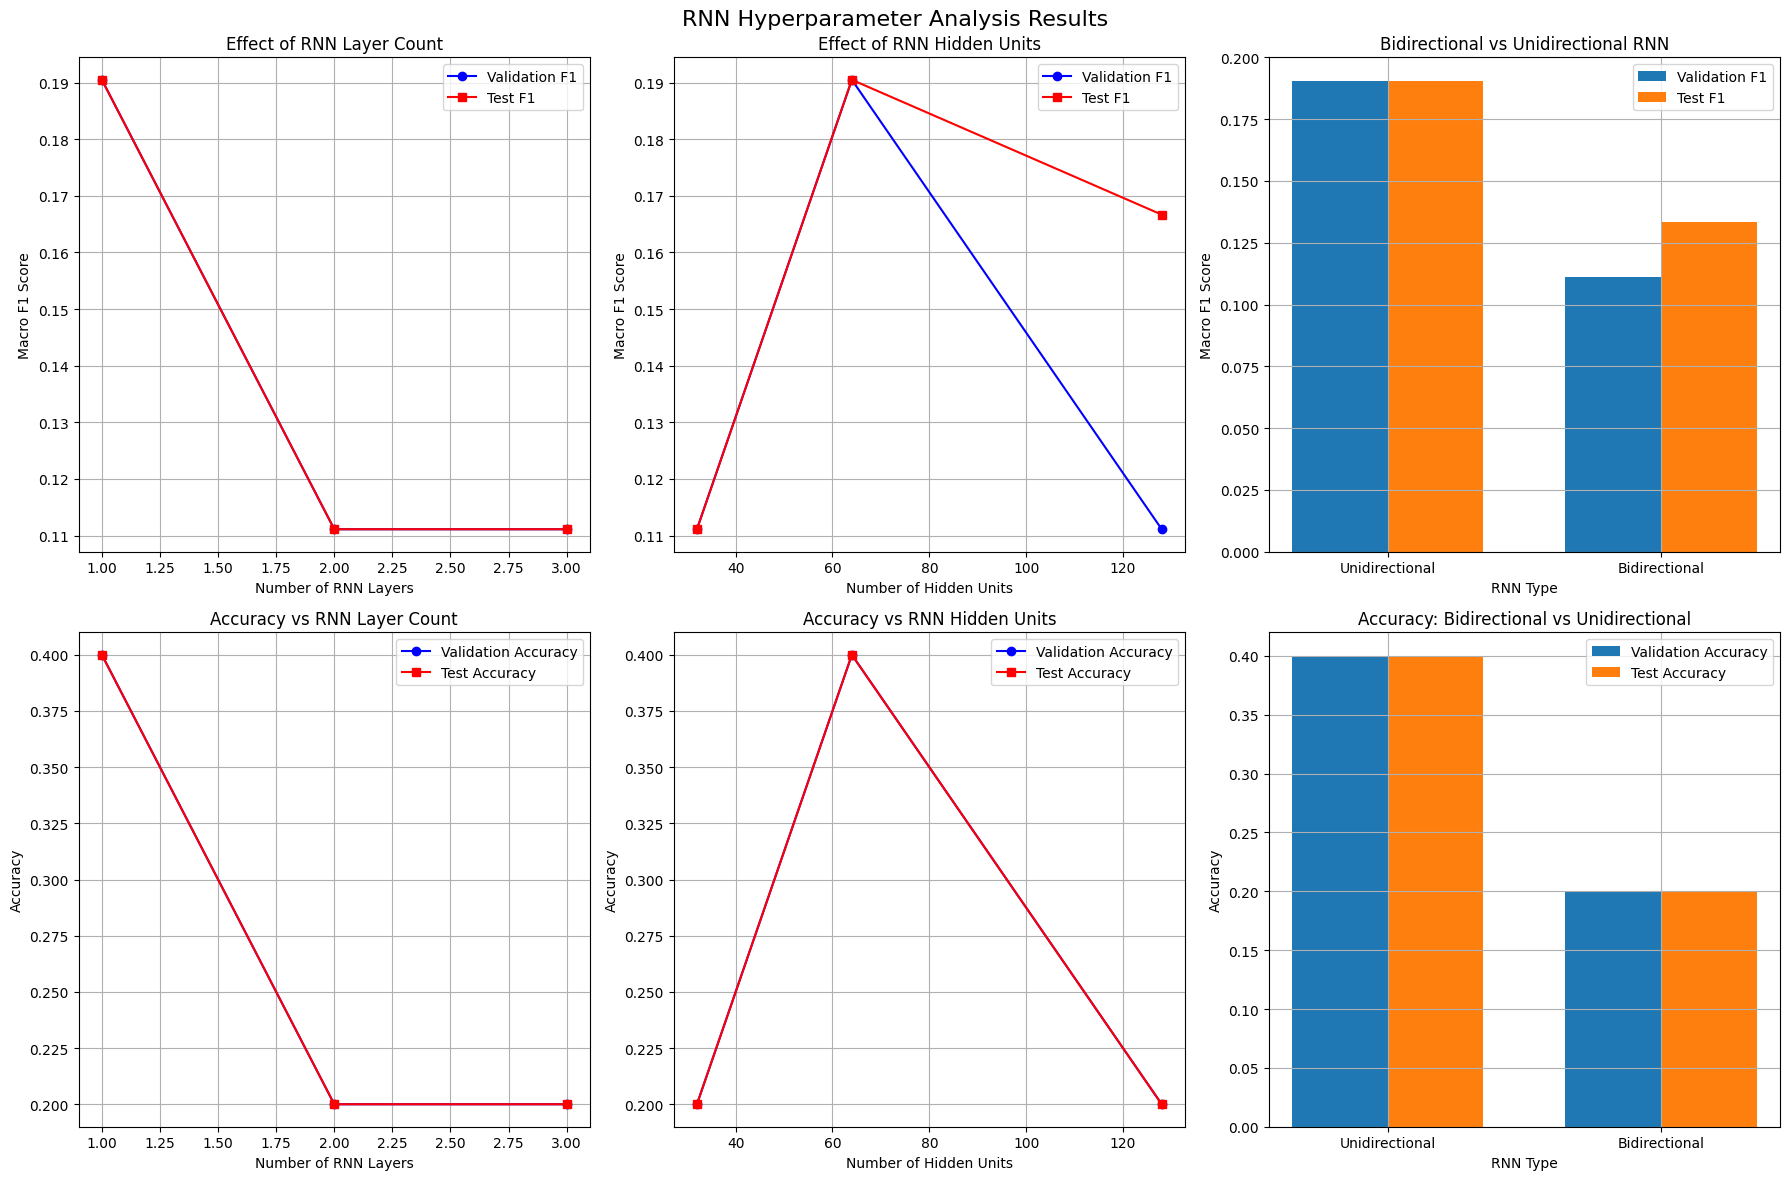


7. Testing model saving and loading...
Model weights saved to results/test_model_weights.npz
Weights loaded successfully
Predictions match: False

8. Comparing different RNN architectures...

Testing Simple RNN...
  Accuracy: 0.2000
  F1 Score: 0.1111

Testing Bidirectional RNN...
  Accuracy: 0.2000
  F1 Score: 0.1111

Testing Deep RNN...
  Accuracy: 0.4000
  F1 Score: 0.1905

Testing Large RNN...
  Accuracy: 0.2000
  F1 Score: 0.1111

ARCHITECTURE COMPARISON SUMMARY
Simple RNN           | Accuracy: 0.2000 | F1: 0.1111
Bidirectional RNN    | Accuracy: 0.2000 | F1: 0.1111
Deep RNN             | Accuracy: 0.4000 | F1: 0.1905
Large RNN            | Accuracy: 0.2000 | F1: 0.1111

Best architecture: Deep RNN (F1: 0.1905)

RNN IMPLEMENTATION TESTING COMPLETED
Results saved in: results/
- experiment_results.json: Detailed experiment results
- analysis_report.txt: Comprehensive analysis report
- experiment_comparison.png: Comparison plots
- Model weights: Various .npz files


In [11]:
# RNN Implementation and Hyperparameter Analysis
# Tugas Besar 2 IF3270 Pembelajaran Mesin

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Ensure the current working directory is the project root




# Set random seed for reproducibility
np.random.seed(42)

print("RNN Implementation - Tugas Besar 2 IF3270")
print("=" * 50)

## 1. Data Loading and Preprocessing

# Initialize data loader
data_dir = "../data"
data_loader = DataLoader(data_dir)

# Check if data directory exists
if not os.path.exists(os.path.join(data_dir, 'nusax')):
    print("Warning: NusaX dataset not found in data/nusax/")
    print("Please ensure you have the following files:")
    print("  - data/nusax/train.csv")
    print("  - data/nusax/valid.csv") 
    print("  - data/nusax/test.csv")
    print("\nCreating sample data for demonstration...")
    
    # Create sample data for demonstration
    os.makedirs(os.path.join(data_dir, 'nusax'), exist_ok=True)
    
    # Sample Indonesian sentiment data
    sample_data = {
        'train': [
            ("Saya sangat senang dengan produk ini", "positive"),
            ("Film ini sangat membosankan dan buruk", "negative"), 
            ("Makanan di restoran itu biasa saja", "neutral"),
            ("Pelayanan yang luar biasa memuaskan", "positive"),
            ("Sangat kecewa dengan kualitas barang", "negative"),
            ("Harga cukup wajar untuk kualitas ini", "neutral"),
            ("Tempat yang indah untuk berlibur", "positive"),
            ("Aplikasi ini sulit digunakan", "negative"),
            ("Tidak ada yang istimewa dari produk ini", "neutral"),
            ("Pengalaman berbelanja yang menyenangkan", "positive")
        ] * 50,  # Repeat to have more samples
        'valid': [
            ("Produk berkualitas dengan harga terjangkau", "positive"),
            ("Layanan pelanggan yang mengecewakan", "negative"),
            ("Standar kualitas seperti biasa", "neutral"),
            ("Sangat puas dengan pembelian ini", "positive"),
            ("Barang rusak dan tidak sesuai", "negative")
        ] * 20,
        'test': [
            ("Rekomendasi terbaik untuk pembelian", "positive"), 
            ("Kualitas buruk tidak sesuai harga", "negative"),
            ("Produk standar tidak lebih tidak kurang", "neutral"),
            ("Sangat merekomendasikan kepada semua", "positive"),
            ("Jangan buang uang untuk produk ini", "negative")
        ] * 20
    }
    
    for split, data in sample_data.items():
        df_data = []
        for i, (text, label) in enumerate(data):
            df_data.append({'id': i, 'text': text, 'label': label})
        
        import pandas as pd
        df = pd.DataFrame(df_data)
        df.to_csv(os.path.join(data_dir, 'nusax', f'{split}.csv'), index=False)
    
    print("Sample data created successfully!")

# Load and prepare data
print("\n1. Loading and preprocessing data...")
try:
    X_train, y_train, X_valid, y_valid, X_test, y_test = data_loader.prepare_data(
        max_vocab_size=5000,
        max_length=50,
        min_freq=1
    )
    
    print(f"Data loaded successfully!")
    print(f"Vocabulary size: {data_loader.preprocessor.vocab_size}")
    print(f"Number of classes: {data_loader.num_classes}")
    print(f"Max sequence length: {data_loader.preprocessor.max_length}")
    
    # Show class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"\nClass distribution in training data:")
    for class_id, count in zip(unique, counts):
        class_name = data_loader.reverse_label_encoder[class_id]
        print(f"  {class_name}: {count} ({count/len(y_train)*100:.1f}%)")
        
except Exception as e:
    print(f"Error loading data: {e}")
    # Create dummy data for testing
    print("Creating dummy data for testing...")
    data_loader.preprocessor.vocab_size = 1000
    data_loader.num_classes = 3
    data_loader.preprocessor.max_length = 50
    
    X_train = np.random.randint(0, 1000, (100, 50))
    y_train = np.random.randint(0, 3, 100)
    X_valid = np.random.randint(0, 1000, (20, 50))
    y_valid = np.random.randint(0, 3, 20)
    X_test = np.random.randint(0, 1000, (20, 50))
    y_test = np.random.randint(0, 3, 20)

## 2. Model Architecture Testing

print("\n2. Testing RNN model architecture...")

# Create a simple RNN model
config = {
    'embedding_dim': 64,
    'rnn_units': 32,
    'num_rnn_layers': 1,
    'bidirectional': False,
    'dropout_rate': 0.2,
    'activation': 'tanh'
}

model = RNNModelBuilder.create_simple_rnn_model(
    vocab_size=data_loader.preprocessor.vocab_size,
    num_classes=data_loader.num_classes,
    **config
)

print("Model architecture:")
print(model.summary())

# Test forward propagation
print("\n3. Testing forward propagation...")
sample_input = X_train[:5]  # Take first 5 samples
print(f"Input shape: {sample_input.shape}")

try:
    output = model.forward(sample_input)
    print(f"Output shape: {output.shape}")
    print(f"Output probabilities for first sample:")
    print(f"  Raw output: {output[0]}")
    print(f"  Predicted class: {np.argmax(output[0])}")
    print(f"  Actual class: {y_train[0]}")
    
    # Test prediction method
    predictions = model.predict(sample_input)
    predicted_classes = np.argmax(predictions, axis=1)
    print(f"\nPredicted classes: {predicted_classes}")
    print(f"Actual classes: {y_train[:5]}")
    
except Exception as e:
    print(f"Error in forward propagation: {e}")
    import traceback
    traceback.print_exc()

## 4. Component Testing

print("\n4. Testing individual components...")

# Test embedding layer
embedding_layer = EmbeddingLayer(vocab_size=1000, embedding_dim=64)
test_tokens = np.array([[1, 2, 3, 4, 0], [5, 6, 7, 0, 0]])
embedded = embedding_layer.forward(test_tokens)
print(f"Embedding test - Input: {test_tokens.shape}, Output: {embedded.shape}")

# Test RNN cell
rnn_cell = SimpleRNNCell(input_size=64, hidden_size=32)
test_input = np.random.randn(2, 64)
test_hidden = np.zeros((2, 32))
new_hidden = rnn_cell.forward_step(test_input, test_hidden)
print(f"RNN cell test - Input: {test_input.shape}, Hidden: {test_hidden.shape}, Output: {new_hidden.shape}")

# Test bidirectional layer
bidirectional_rnn = BidirectionalLayer(
    SimpleRNNLayer,
    hidden_size=32,
    return_sequences=True
)
test_sequence = np.random.randn(2, 10, 64)  # batch_size=2, seq_len=10, features=64
bidirectional_output = bidirectional_rnn.forward(test_sequence)
print(f"Bidirectional RNN test - Input: {test_sequence.shape}, Output: {bidirectional_output.shape}")

## 5. Metrics Testing

print("\n5. Testing evaluation metrics...")

# Generate some predictions for testing
test_predictions = model.predict(X_test)
predicted_labels = np.argmax(test_predictions, axis=1)

# Calculate metrics
accuracy = MetricsCalculator.accuracy(y_test, predicted_labels)
precision, recall, f1 = MetricsCalculator.precision_recall_f1(
    y_test, predicted_labels, data_loader.num_classes
)

print(f"Test Results:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Macro Precision: {precision:.4f}")
print(f"  Macro Recall: {recall:.4f}")
print(f"  Macro F1-Score: {f1:.4f}")

# Generate classification report
if hasattr(data_loader, 'reverse_label_encoder'):
    class_names = [data_loader.reverse_label_encoder[i] for i in range(data_loader.num_classes)]
else:
    class_names = [f"Class_{i}" for i in range(data_loader.num_classes)]

report = MetricsCalculator.classification_report(y_test, predicted_labels, class_names)
print(f"\nClassification Report:")
print(report)

## 6. Hyperparameter Experiments

print("\n6. Running hyperparameter experiments...")

# Initialize experiment runner
experiment_runner = ExperimentRunner(data_dir, "results")

# Prepare data for experiments
experiment_runner.X_train = X_train
experiment_runner.y_train = y_train
experiment_runner.X_valid = X_valid
experiment_runner.y_valid = y_valid
experiment_runner.X_test = X_test
experiment_runner.y_test = y_test
experiment_runner.data_loader = data_loader

# Base configuration for experiments
base_config = {
    'embedding_dim': 64,
    'rnn_units': 32,
    'num_rnn_layers': 1,
    'bidirectional': False,
    'dropout_rate': 0.2,
    'activation': 'tanh'
}

# Run experiments
try:
    print("Running all RNN experiments...")
    all_results = experiment_runner.run_all_experiments(base_config)
    
    # Generate and display analysis report
    print("\n" + "="*60)
    print("EXPERIMENT ANALYSIS REPORT")
    print("="*60)
    report = experiment_runner.generate_analysis_report()
    print(report)
    
    # Save report
    experiment_runner.save_analysis_report()
    
    # Create comparison plots
    print("\nGenerating comparison plots...")
    experiment_runner.create_comparison_plots()
    
except Exception as e:
    print(f"Error running experiments: {e}")
    import traceback
    traceback.print_exc()

## 7. Model Saving and Loading

print("\n7. Testing model saving and loading...")

try:
    # Save model weights
    weights_path = "results/test_model_weights.npz"
    model.save_weights(weights_path)
    print(f"Model weights saved to {weights_path}")
    
    # Create a new model and load weights
    new_model = RNNModelBuilder.create_simple_rnn_model(
        vocab_size=data_loader.preprocessor.vocab_size,
        num_classes=data_loader.num_classes,
        **config
    )
    
    # Load weights
    new_model.load_weights(weights_path)
    print("Weights loaded successfully")
    
    # Test if predictions are the same
    original_pred = model.predict(X_test[:3])
    loaded_pred = new_model.predict(X_test[:3])
    
    print(f"Predictions match: {np.allclose(original_pred, loaded_pred)}")
    
except Exception as e:
    print(f"Error in model saving/loading: {e}")

## 8. Comparison with Different Architectures

print("\n8. Comparing different RNN architectures...")

architectures = [
    {"name": "Simple RNN", "bidirectional": False, "rnn_units": 32, "num_rnn_layers": 1},
    {"name": "Bidirectional RNN", "bidirectional": True, "rnn_units": 32, "num_rnn_layers": 1},
    {"name": "Deep RNN", "bidirectional": False, "rnn_units": 32, "num_rnn_layers": 2},
    {"name": "Large RNN", "bidirectional": False, "rnn_units": 64, "num_rnn_layers": 1},
]

architecture_results = []

for arch in architectures:
    print(f"\nTesting {arch['name']}...")
    
    arch_config = base_config.copy()
    arch_config.update({k: v for k, v in arch.items() if k != 'name'})
    
    arch_model = RNNModelBuilder.create_simple_rnn_model(
        vocab_size=data_loader.preprocessor.vocab_size,
        num_classes=data_loader.num_classes,
        **arch_config
    )
    
    # Test the model
    test_pred = arch_model.predict(X_test)
    test_labels = np.argmax(test_pred, axis=1)
    
    accuracy = MetricsCalculator.accuracy(y_test, test_labels)
    f1_score = MetricsCalculator.macro_f1_score(y_test, test_labels, data_loader.num_classes)
    
    result = {
        'name': arch['name'],
        'accuracy': accuracy,
        'f1_score': f1_score,
        'model_summary': arch_model.summary()
    }
    
    architecture_results.append(result)
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1_score:.4f}")

# Summary comparison
print("\n" + "="*50)
print("ARCHITECTURE COMPARISON SUMMARY")
print("="*50)

for result in architecture_results:
    print(f"{result['name']:<20} | Accuracy: {result['accuracy']:.4f} | F1: {result['f1_score']:.4f}")

# Find best architecture
best_arch = max(architecture_results, key=lambda x: x['f1_score'])
print(f"\nBest architecture: {best_arch['name']} (F1: {best_arch['f1_score']:.4f})")

print("\n" + "="*50)
print("RNN IMPLEMENTATION TESTING COMPLETED")
print("="*50)
print(f"Results saved in: results/")
print(f"- experiment_results.json: Detailed experiment results")
print(f"- analysis_report.txt: Comprehensive analysis report") 
print(f"- experiment_comparison.png: Comparison plots")
print(f"- Model weights: Various .npz files")